In [1]:
%pip install sas-pip/

Processing ./sas-pip
  Preparing metadata (setup.py) ... done
  Created wheel for sas: filename=sas-1.0-py3-none-any.whl size=6290 sha256=d80e87de7ee2a92c271d90b3898e2294eb803af95e7508884f624f29f110c741
  Stored in directory: /Users/jefferyqin/Library/Caches/pip/wheels/c3/c7/80/251166f03cb55d2fafc1a4fe53bdfe5780e3347b9f032879b9
Successfully built sas
  Attempting uninstall: sas
    Found existing installation: sas 1.0
    Uninstalling sas-1.0:
      Successfully uninstalled sas-1.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torchvision.transforms as transforms
mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
transform_train = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
import torchvision
from torchvision import transforms

cifar100 = torchvision.datasets.CIFAR100("./data/cifar100/", transform=transform_train,download=True)
device = "cuda:0"

Files already downloaded and verified


In [3]:
# import torchvision
# from torchvision import transforms

# cifar100 = torchvision.datasets.CIFAR100("cifar100/", transform=transforms.ToTensor(), download=True)
# device = "mps"

Files already downloaded and verified


In [2]:
from sas.approx_latent_classes import clip_approx
from sas.subset_dataset import SASSubsetDataset
import random 

rand_labeled_examples_indices = random.sample(range(len(cifar100)), 500)
rand_labeled_examples_labels = [cifar100[i][1] for i in rand_labeled_examples_indices]

partition = clip_approx(
    img_trainset=cifar100,
    labeled_example_indices=rand_labeled_examples_indices, 
    labeled_examples_labels=rand_labeled_examples_labels,
    num_classes=100,
    device = device
)

In [3]:
from torch import nn 

class ProxyModel(nn.Module):
    def __init__(self, net, critic):
        super().__init__()
        self.net = net
        self.critic = critic
    def forward(self, x):
        return self.critic.project(self.net(x))

## balanced_cifar

In [6]:
from sklearn.model_selection import train_test_split

labels = [cifar100[i][1] for i in range(len(cifar100))]
indices = range(len(cifar100))
(
    cifar_balanced,
    _,
    labels_train,
    _,
    indices_train,
    _,
) = train_test_split(cifar100, labels, indices, test_size=0.5, stratify=labels)

In [7]:
cifar = cifar_balanced + cifar_balanced

In [8]:
len(cifar)

50000

In [9]:
import torch 

net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('mps'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('mps'))
proxy_model = ProxyModel(net, critic)
device = "mps"
     
subset_dataset_balanced = SASSubsetDataset(
    dataset=cifar,
    subset_fraction=0.2,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|████████████████████████| 99/99 [00:02<00:00, 38.96it/s]

Subset Size: 10000
Discarded 40000 examples


In [10]:
len(subset_dataset_balanced.subset_indices)

9958

In [11]:
count_balanced = {}
for x,y in subset_dataset_balanced:
    if y not in count_balanced:
        count_balanced[y] = 1
    else:
        count_balanced[y]+=1

Keys = list(count_balanced.keys())
Keys.sort()
sorted_dict_balanced = {i: count_balanced[i] for i in Keys}
print(sorted_dict_balanced)

{0: 9, 1: 152, 2: 113, 3: 94, 4: 205, 5: 54, 6: 101, 7: 114, 8: 47, 9: 37, 10: 58, 11: 63, 12: 86, 13: 29, 14: 162, 15: 101, 16: 28, 17: 31, 18: 197, 19: 114, 20: 14, 21: 92, 22: 24, 23: 82, 24: 35, 25: 65, 26: 127, 27: 282, 28: 94, 29: 62, 30: 171, 31: 96, 32: 125, 33: 92, 34: 152, 35: 74, 36: 74, 37: 53, 38: 195, 39: 17, 40: 118, 41: 58, 42: 125, 43: 108, 44: 201, 45: 127, 46: 110, 47: 13, 48: 27, 49: 86, 50: 196, 51: 113, 52: 21, 53: 7, 54: 69, 55: 201, 56: 31, 57: 54, 58: 24, 59: 41, 60: 36, 61: 18, 62: 51, 63: 222, 64: 158, 65: 217, 66: 148, 67: 208, 68: 64, 69: 158, 70: 58, 71: 108, 72: 166, 73: 143, 74: 242, 75: 91, 76: 127, 77: 181, 78: 129, 79: 202, 80: 254, 81: 29, 82: 19, 83: 41, 84: 67, 85: 77, 86: 28, 87: 50, 88: 122, 89: 54, 90: 66, 91: 141, 92: 78, 93: 178, 94: 17, 95: 136, 96: 56, 97: 121, 98: 92, 99: 154}


In [12]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_balanced[i]
    else:
        num_bigger50 += count_balanced[i]
        
print(num_less50, num_bigger50)

4694 5264


## imbalanced_cifar

In [4]:
from collections import defaultdict, Counter
import numpy as np
import random

labels = [cifar100[i][1] for i in range(len(cifar100))]
indices = range(len(cifar100))

dic = defaultdict(list)
cifar_imbalanced = []

for i in range(len(cifar100)):
    label = cifar100[i][1]
    dic[label].append(i)

In [5]:
selected_indices = []
for label in dic.keys():
    if label < 50:
        selected_indices += random.sample(dic[label], 50)
    else:
        selected_indices += random.sample(dic[label], 450)
        
random.shuffle(selected_indices)

cifar_imbalanced = []
for i in selected_indices:
    cifar_imbalanced.append(cifar100[i])

In [6]:
print(len(cifar_imbalanced))

25000


In [7]:
cifar_im = cifar_imbalanced + cifar_imbalanced
random.shuffle(cifar_im)

len(cifar_im)

50000

In [ ]:
import torch 

net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('mps'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('mps'))
proxy_model = ProxyModel(net, critic)
device = "mps"
     
subset_dataset_imbalanced = SASSubsetDataset(
    dataset=cifar_im,
    subset_fraction=0.2,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|████████████████████████| 99/99 [00:02<00:00, 38.27it/s]

Subset Size: 10000
Discarded 40000 examples


In [20]:
len(subset_dataset_imbalanced.subset_indices)

9958

In [21]:
count_imbalanced = {}
for x,y in subset_dataset_imbalanced:
    if y not in count_imbalanced:
        count_imbalanced[y] = 1
    else:
        count_imbalanced[y]+=1

Keys = list(count_imbalanced.keys())
Keys.sort()
sorted_dict_imbalanced = {i: count_imbalanced[i] for i in Keys}
print(sorted_dict_imbalanced)

{0: 4, 1: 30, 2: 14, 3: 14, 4: 32, 5: 4, 6: 18, 7: 15, 8: 3, 9: 8, 10: 16, 11: 13, 12: 13, 13: 4, 14: 31, 15: 11, 16: 9, 17: 3, 18: 39, 19: 16, 20: 3, 21: 18, 22: 1, 23: 20, 24: 4, 25: 11, 26: 26, 27: 47, 28: 8, 29: 8, 30: 36, 31: 25, 32: 20, 33: 19, 34: 30, 35: 8, 36: 11, 37: 11, 38: 27, 39: 4, 40: 17, 41: 3, 42: 16, 43: 23, 44: 30, 45: 12, 46: 8, 47: 8, 48: 2, 49: 26, 50: 324, 51: 215, 52: 34, 53: 24, 54: 183, 55: 339, 56: 75, 57: 114, 58: 49, 59: 77, 60: 154, 61: 12, 62: 150, 63: 356, 64: 280, 65: 309, 66: 238, 67: 377, 68: 116, 69: 259, 70: 135, 71: 275, 72: 287, 73: 314, 74: 434, 75: 159, 76: 191, 77: 316, 78: 175, 79: 313, 80: 395, 81: 37, 82: 62, 83: 83, 84: 61, 85: 146, 86: 38, 87: 72, 88: 168, 89: 74, 90: 103, 91: 228, 92: 175, 93: 290, 94: 23, 95: 265, 96: 118, 97: 196, 98: 102, 99: 259}


In [22]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_imbalanced[i]
    else:
        num_bigger50 += count_imbalanced[i]
        
print(num_less50, num_bigger50)

779 9179


## Downsampling and Upsampling

In [23]:
cifar_im_less50 = []
cifar_im_bigger50 = []

for x,y in cifar_im:
    if y < 50:
        cifar_im_less50.append((x,y))
    else:
        cifar_im_bigger50.append((x,y))

In [24]:
print(len(cifar_im_less50), len(cifar_im_bigger50))

5000 45000


In [25]:
from sklearn.utils import resample

cifar_im_less50 = resample(cifar_im_less50,
             replace=True,
             n_samples=25000,
             random_state=42)

cifar_im_bigger50 = resample(cifar_im_bigger50,
             replace=True,
             n_samples=25000,
             random_state=42)

In [26]:
print(len(cifar_im_less50), len(cifar_im_bigger50))

25000 25000


In [27]:
cifar_sampled = cifar_im_less50 + cifar_im_bigger50
random.shuffle(cifar_sampled)

In [28]:
import torch 

net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('mps'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('mps'))
proxy_model = ProxyModel(net, critic)
device = "mps"
     
subset_dataset_sampled = SASSubsetDataset(
    dataset=cifar_sampled,
    subset_fraction=0.2,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|████████████████████████| 99/99 [00:02<00:00, 38.04it/s]

Subset Size: 10000
Discarded 40000 examples


In [29]:
len(subset_dataset_sampled.subset_indices)

9958

In [30]:
count_sampled = {}
for x,y in subset_dataset_sampled:
    if y not in count_sampled:
        count_sampled[y] = 1
    else:
        count_sampled[y]+=1

Keys = list(count_sampled.keys())
Keys.sort()
sorted_dict_sampled = {i: count_sampled[i] for i in Keys}
print(sorted_dict_sampled)

{0: 7, 1: 145, 2: 111, 3: 83, 4: 184, 5: 66, 6: 130, 7: 94, 8: 33, 9: 61, 10: 85, 11: 73, 12: 76, 13: 31, 14: 172, 15: 76, 16: 47, 17: 40, 18: 186, 19: 99, 20: 22, 21: 99, 22: 23, 23: 67, 24: 38, 25: 87, 26: 167, 27: 243, 28: 90, 29: 53, 30: 121, 31: 155, 32: 163, 33: 90, 34: 149, 35: 55, 36: 108, 37: 64, 38: 200, 39: 11, 40: 126, 41: 34, 42: 109, 43: 131, 44: 158, 45: 88, 46: 85, 47: 27, 48: 30, 49: 80, 50: 212, 51: 113, 52: 13, 53: 10, 54: 80, 55: 226, 56: 44, 57: 52, 58: 29, 59: 45, 60: 58, 61: 20, 62: 56, 63: 196, 64: 169, 65: 218, 66: 137, 67: 190, 68: 48, 69: 174, 70: 48, 71: 114, 72: 140, 73: 163, 74: 249, 75: 81, 76: 132, 77: 186, 78: 108, 79: 208, 80: 255, 81: 39, 82: 26, 83: 29, 84: 67, 85: 86, 86: 30, 87: 85, 88: 116, 89: 62, 90: 54, 91: 130, 92: 71, 93: 168, 94: 20, 95: 133, 96: 67, 97: 116, 98: 74, 99: 139}


In [31]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_sampled[i]
    else:
        num_bigger50 += count_sampled[i]
        
print(num_less50, num_bigger50)

4672 5286


## New Version Up-down Sampling

In [50]:
samples = [[] for _ in range(100)]

for i, (x,y) in enumerate(cifar_im):
    samples[y].append(cifar_im[i])

In [52]:
from sklearn.utils import resample

for i in range(len(samples)):
    samples[i] = resample(samples[i],
             replace=True,
             n_samples=500,
             random_state=42)
    
for sample in samples:
    print(len(sample))

cifar_sampled_new = sum(samples, [])
print(len(cifar_sampled_new))
random.shuffle(cifar_sampled_new)

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
50000


In [53]:
net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('mps'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('mps'))
proxy_model = ProxyModel(net, critic)
device = "mps"
     
subset_dataset_sampled_new = SASSubsetDataset(
    dataset=cifar_sampled_new,
    subset_fraction=0.2,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|████████████████████████| 99/99 [00:02<00:00, 38.96it/s]


Subset Size: 10000
Discarded 40000 examples


In [54]:
len(subset_dataset_sampled_new.subset_indices)

9958

In [55]:
count_sampled_new = {}
for x,y in subset_dataset_sampled_new:
    if y not in count_sampled_new:
        count_sampled_new[y] = 1
    else:
        count_sampled_new[y]+=1

Keys = list(count_sampled_new.keys())
Keys.sort()
sorted_dict_sampled_new = {i: count_sampled_new[i] for i in Keys}
print(sorted_dict_sampled_new)

{0: 11, 1: 137, 2: 81, 3: 96, 4: 179, 5: 70, 6: 114, 7: 99, 8: 29, 9: 76, 10: 82, 11: 86, 12: 72, 13: 23, 14: 177, 15: 69, 16: 41, 17: 42, 18: 196, 19: 99, 20: 22, 21: 109, 22: 20, 23: 83, 24: 33, 25: 68, 26: 154, 27: 230, 28: 90, 29: 45, 30: 157, 31: 145, 32: 182, 33: 99, 34: 147, 35: 54, 36: 71, 37: 41, 38: 191, 39: 14, 40: 139, 41: 27, 42: 92, 43: 133, 44: 150, 45: 91, 46: 90, 47: 39, 48: 17, 49: 89, 50: 192, 51: 118, 52: 11, 53: 11, 54: 87, 55: 191, 56: 38, 57: 68, 58: 33, 59: 38, 60: 46, 61: 15, 62: 53, 63: 196, 64: 181, 65: 218, 66: 139, 67: 228, 68: 39, 69: 181, 70: 60, 71: 100, 72: 166, 73: 166, 74: 275, 75: 95, 76: 137, 77: 201, 78: 109, 79: 243, 80: 242, 81: 26, 82: 29, 83: 39, 84: 63, 85: 80, 86: 29, 87: 73, 88: 102, 89: 56, 90: 58, 91: 109, 92: 73, 93: 162, 94: 21, 95: 124, 96: 74, 97: 119, 98: 83, 99: 160}


In [56]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_sampled_new[i]
    else:
        num_bigger50 += count_sampled_new[i]
        
print(num_less50, num_bigger50)

4601 5357


In [150]:
print(subset_dataset_sampled_new.subset_indices)

[44742, 5750, 19561, 5946, 13665, 44324, 27283, 22502, 39096, 28663, 4283, 12460, 20214, 25827, 5601, 20664, 23992, 17773, 4639, 26824, 8252, 18628, 49628, 4556, 29824, 137, 180, 686, 21778, 41450, 41911, 6658, 42395, 18084, 4302, 19779, 18457, 16908, 5397, 39853, 13919, 41243, 3718, 32562, 21815, 15855, 42384, 3611, 35334, 3046, 42771, 42182, 5383, 15984, 25588, 49377, 41367, 40825, 24688, 28983, 9205, 31854, 5540, 7298, 41938, 17371, 351, 44140, 32415, 1850, 26909, 40658, 11019, 35477, 24347, 23113, 28619, 40133, 12812, 15065, 491, 29661, 44006, 17444, 73, 6286, 40743, 25069, 49770, 42867, 1052, 26861, 38484, 3006, 31906, 278, 33611, 44362, 46744, 16569, 2412, 4592, 27538, 46467, 34860, 49758, 23341, 677, 7897, 49160, 16116, 49973, 22477, 3171, 24122, 43105, 39878, 19794, 41592, 9726, 38265, 2348, 4953, 37600, 29880, 40358, 32819, 35655, 15374, 49194, 24773, 42021, 11706, 19872, 9442, 3728, 31141, 42411, 41777, 18030, 47592, 16843, 45031, 24054, 12483, 9901, 18756, 36662, 8504, 23137

### Data Augumentation

In [8]:
%pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [8]:
labels = [cifar100[i][1] for i in range(len(cifar100))]
indices = range(len(cifar100))

dic = defaultdict(list)
cifar_balanced = []

for i in range(len(cifar100)):
    label = cifar100[i][1]
    dic[label].append(i)

In [9]:
samples = [[] for _ in range(100)]

for i, (x,y) in enumerate(cifar_im):
    samples[y].append(x)

# 新加的
for label in dic.keys():
    if label >= 50:
        selected_indices = dic[label]
        sample = []
        for i in selected_indices:
            sample.append(cifar100[i][0])
        samples[label] = sample
    
length = []
for sample in samples:
    length.append(len(sample))

In [10]:
print(length)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [11]:
from torchvision.utils import save_image
import os

for i in range(100):
    if not os.path.exists('./images/class{}/'.format(i)):
        os.makedirs('./images/class{}/'.format(i))

for i in range(len(samples)):
    for j in range(len(samples[i])):
        save_image(samples[i][j], './images/class{}/img{}.png'.format(i,j))

In [12]:
import Augmentor

for i in range(100):
    path_to_data = "./images/class{}".format(i)
    
    # Create a pipeline
    p = Augmentor.Pipeline(path_to_data)
    
    # Add a horizontal flip operation to the pipeline:
    p.flip_left_right(probability=0.4)

    # Add a vertical flip operation to the pipeline:
    p.flip_top_bottom(probability=0.8)

    # Add a rotate90 operation to the pipeline:
    p.rotate90(probability=0.1)

    p.skew(0.4, 0.5)

    p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
    
    num_of_samples = 500 - length[i]
    
    if num_of_samples > 0:
        # Now we can sample from the pipeline:
        p.sample(num_of_samples)

Initialised with 100 image(s) found.
Output directory set to ./images/class0\output.

Executing Pipeline:   0%|          | 0/400 [00:00<?, ? Samples/s]

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D38B760>: 100%|██████████| 400/400 [00:00<00:00, 865.61 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class1\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3FA620>: 100%|██████████| 400/400 [00:00<00:00, 940.97 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class2\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D38B3A0>: 100%|██████████| 400/400 [00:00<00:00, 921.45 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class3\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3F8220>: 100%|██████████| 400/400 [00:00<00:00, 878.75 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class4\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D446980>: 100%|██████████| 400/400 [00:00<00:00, 904.77 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class5\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47D570>: 100%|██████████| 400/400 [00:00<00:00, 949.90 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class6\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D38B6D0>: 100%|██████████| 400/400 [00:00<00:00, 921.45 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class7\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3FA1D0>: 100%|██████████| 400/400 [00:00<00:00, 905.61 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class8\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3FB4F0>: 100%|██████████| 400/400 [00:00<00:00, 867.49 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class9\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D429B40>: 100%|██████████| 400/400 [00:00<00:00, 943.17 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class10\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D40DB40>: 100%|██████████| 400/400 [00:00<00:00, 875.52 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class11\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D429B40>: 100%|██████████| 400/400 [00:00<00:00, 878.90 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class12\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3F8100>: 100%|██████████| 400/400 [00:00<00:00, 740.57 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class13\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D38AA10>: 100%|██████████| 400/400 [00:00<00:00, 902.70 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class14\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3F8B80>: 100%|██████████| 400/400 [00:00<00:00, 929.99 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class15\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D4294B0>: 100%|██████████| 400/400 [00:00<00:00, 943.18 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class16\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D389CC0>: 100%|██████████| 400/400 [00:00<00:00, 892.66 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class17\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D428400>: 100%|██████████| 400/400 [00:00<00:00, 916.13 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class18\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3CAC50>: 100%|██████████| 400/400 [00:00<00:00, 887.68 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class19\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D388FD0>: 100%|██████████| 400/400 [00:00<00:00, 955.57 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class20\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3FB220>: 100%|██████████| 400/400 [00:00<00:00, 904.98 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class21\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D389F90>: 100%|██████████| 400/400 [00:00<00:00, 877.95 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class22\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D447130>: 100%|██████████| 400/400 [00:00<00:00, 944.26 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class23\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D389960>: 100%|██████████| 400/400 [00:00<00:00, 918.25 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class24\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D446C80>: 100%|██████████| 400/400 [00:00<00:00, 798.22 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class25\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D428E20>: 100%|██████████| 400/400 [00:00<00:00, 933.27 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class26\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47E8C0>: 100%|██████████| 400/400 [00:00<00:00, 863.74 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class27\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D428C40>: 100%|██████████| 400/400 [00:00<00:00, 926.75 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class28\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x2303D47D060>: 100%|██████████| 400/400 [00:00<00:00, 932.16 Samples/s] 


Initialised with 100 image(s) found.
Output directory set to ./images/class29\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3C80D0>: 100%|██████████| 400/400 [00:00<00:00, 860.00 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class30\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3CB190>: 100%|██████████| 400/400 [00:00<00:00, 861.87 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class31\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D42BB50>: 100%|██████████| 400/400 [00:00<00:00, 936.56 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class32\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3F8E20>: 100%|██████████| 400/400 [00:00<00:00, 854.48 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class33\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D40CA00>: 100%|██████████| 400/400 [00:00<00:00, 754.07 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class34\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3FB730>: 100%|██████████| 400/400 [00:00<00:00, 753.83 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class35\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3CB1F0>: 100%|██████████| 400/400 [00:00<00:00, 867.48 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class36\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D4462F0>: 100%|██████████| 400/400 [00:00<00:00, 840.15 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class37\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D389210>: 100%|██████████| 400/400 [00:00<00:00, 845.47 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class38\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47EDA0>: 100%|██████████| 400/400 [00:00<00:00, 865.60 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class39\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D3C9180>: 100%|██████████| 400/400 [00:00<00:00, 853.07 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class40\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47E320>: 100%|██████████| 400/400 [00:00<00:00, 913.03 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class41\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D40D630>: 100%|██████████| 400/400 [00:00<00:00, 870.28 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class42\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47F3A0>: 100%|██████████| 400/400 [00:00<00:00, 871.26 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class43\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D45D360>: 100%|██████████| 400/400 [00:00<00:00, 914.04 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class44\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D447DF0>: 100%|██████████| 400/400 [00:00<00:00, 877.56 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class45\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47EA10>: 100%|██████████| 400/400 [00:00<00:00, 865.58 Samples/s]                


Initialised with 100 image(s) found.
Output directory set to ./images/class46\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D389330>: 100%|██████████| 400/400 [00:00<00:00, 896.66 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class47\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D45E230>: 100%|██████████| 400/400 [00:00<00:00, 869.35 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class48\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D38AAA0>: 100%|██████████| 400/400 [00:00<00:00, 906.63 Samples/s]                 


Initialised with 100 image(s) found.
Output directory set to ./images/class49\output.

Processing <PIL.Image.Image image mode=RGB size=32x32 at 0x2303D47ED10>: 100%|██████████| 400/400 [00:00<00:00, 923.58 Samples/s]                


Initialised with 500 image(s) found.
Output directory set to ./images/class50\output.Initialised with 500 image(s) found.
Output directory set to ./images/class51\output.Initialised with 500 image(s) found.
Output directory set to ./images/class52\output.Initialised with 500 image(s) found.
Output directory set to ./images/class53\output.Initialised with 500 image(s) found.
Output directory set to ./images/class54\output.Initialised with 500 image(s) found.
Output directory set to ./images/class55\output.Initialised with 500 image(s) found.
Output directory set to ./images/class56\output.Initialised with 500 image(s) found.
Output directory set to ./images/class57\output.Initialised with 500 image(s) found.
Output directory set to ./images/class58\output.Initialised with 500 image(s) found.
Output directory set to ./images/class59\output.Initialised with 500 image(s) found.
Output directory set to ./images/class60\output.Initialised with 500 image(s) found.
Output directory set to ./im

In [13]:
from sklearn.utils import resample

for i in range(len(samples)):
    if len(samples[i]) > 500:
        print('exist')
        samples[i] = resample(samples[i],
                 replace=True,
                 n_samples=500,
                 random_state=42)

In [14]:
import torchvision

augumented_images = [[] for _ in range(100)]

for i in range(100):
    if length[i] < 500:
        files = [f for f in os.listdir('./images/class{}/output/'.format(i)) if 'png' in f]
        for f in files:
            augumented_images[i].append(torchvision.io.read_image('./images/class{}/output/'.format(i)+f)/256)

In [15]:
for sample in augumented_images:
    print(len(sample))

400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [16]:
new_cifar = []
for i in range(100):
    if len(samples[i]) == 500:
        for sample in samples[i]:
            new_cifar.append((sample, i))
    else:
        for sample in samples[i]:
            new_cifar.append((sample, i))
        for sample in augumented_images[i]:
            new_cifar.append((sample, i))
print(len(new_cifar))
random.shuffle(new_cifar)

50000


In [17]:
less50 = 0
more50 = 0
for x,y in new_cifar:
    if y<50:
        less50+=1
    else:
        more50+=1
print(less50,more50)

25000 25000


In [18]:
from train_changedata import main

best_acc, confusion_matrix , best_f1, best_recall = main(train_dataset= new_cifar)


{'net': 'vgg16', 'gpu': True, 'b': 100, 'warm': 1, 'lr': 0.1, 'resume': False}
train_data loader is ready
Files already downloaded and verified
test_data loader is ready
Training Epoch: 1 [50000/50000]	Loss: 4.1055	LR: 0.100000
epoch 1 training time consumed: 87.32s
Evaluating Network.....
Test set: Epoch: 1, Average loss: 0.0460, Accuracy: 0.0387, Time consumed:17.82s



d:\anaconda\anaconda3\envs\260d\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Epoch: 2 [50000/50000]	Loss: 3.8204	LR: 0.100000
epoch 2 training time consumed: 57.71s
Evaluating Network.....
Test set: Epoch: 2, Average loss: 0.0431, Accuracy: 0.0553, Time consumed:14.68s

Training Epoch: 3 [50000/50000]	Loss: 3.7396	LR: 0.100000
epoch 3 training time consumed: 57.43s
Evaluating Network.....
Test set: Epoch: 3, Average loss: 0.0423, Accuracy: 0.0674, Time consumed:14.92s

Training Epoch: 4 [50000/50000]	Loss: 3.7587	LR: 0.100000
epoch 4 training time consumed: 57.31s
Evaluating Network.....
Test set: Epoch: 4, Average loss: 0.0420, Accuracy: 0.0834, Time consumed:14.62s

Training Epoch: 5 [50000/50000]	Loss: 3.5754	LR: 0.100000
epoch 5 training time consumed: 56.79s
Evaluating Network.....
Test set: Epoch: 5, Average loss: 0.0436, Accuracy: 0.0761, Time consumed:14.52s

Training Epoch: 6 [50000/50000]	Loss: 3.6046	LR: 0.100000
epoch 6 training time consumed: 57.14s
Evaluating Network.....
Test set: Epoch: 6, Average loss: 0.0417, Accuracy: 0.0999, Time co

best accuracy: tensor(0.4036, device='cuda:0')
best f1score tensor(0.4036)
best recall tensor(0.4036)
[[52  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  1  2]
 [ 0  0 15 ...  1 30  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  1 ...  1 56  1]
 [ 0  0  1 ...  0  0 53]]


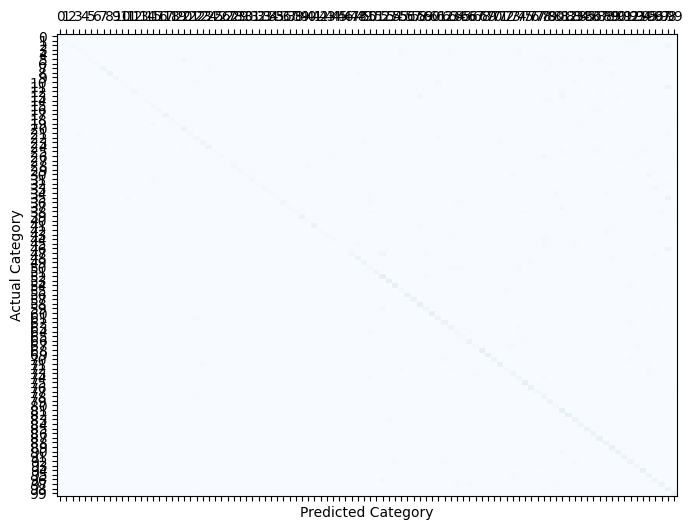

In [19]:
print('best accuracy:',best_acc)
print('best f1score',best_f1)
print('best recall',best_recall)

print(confusion_matrix)
import matplotlib.pyplot as plt

classes = range(100)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(100), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(100), classes)
plt.show()

### train on subset

In [20]:
import torch
net = torch.load("proxy-cifar100-resnet10-399-net.pt", map_location=torch.device('cuda:0'))
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt", map_location=torch.device('cuda:0'))
proxy_model = ProxyModel(net, critic)
device = "cuda:0"
     
subset_dataset_new = SASSubsetDataset(
    dataset=new_cifar,
    subset_fraction=0.8,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|██████████| 99/99 [00:03<00:00, 26.90it/s]

Subset Size: 40000
Discarded 10000 examples


In [21]:
len(subset_dataset_new.subset_indices)

39962

In [148]:
count_new = {}
for x,y in subset_dataset_new:
    if y not in count_new:
        count_new[y] = 1
    else:
        count_new[y]+=1

Keys = list(count_new.keys())
Keys.sort()
sorted_dict_new = {i: count_new[i] for i in Keys}
print(sorted_dict_new)

{0: 62, 1: 180, 2: 138, 3: 150, 4: 178, 5: 177, 6: 100, 7: 92, 8: 55, 9: 60, 10: 99, 11: 110, 12: 80, 13: 28, 14: 149, 15: 138, 16: 40, 17: 90, 18: 184, 19: 125, 20: 53, 21: 178, 22: 33, 23: 136, 24: 40, 25: 141, 26: 147, 27: 198, 28: 132, 29: 73, 30: 176, 31: 163, 32: 175, 33: 111, 34: 186, 35: 125, 36: 163, 37: 61, 38: 177, 39: 37, 40: 171, 41: 52, 42: 106, 43: 153, 44: 162, 45: 98, 46: 134, 47: 83, 48: 42, 49: 180, 50: 177, 51: 82, 52: 3, 53: 3, 54: 58, 55: 175, 56: 25, 57: 50, 58: 19, 59: 13, 60: 33, 61: 10, 62: 34, 63: 123, 64: 145, 65: 178, 66: 100, 67: 171, 68: 21, 69: 151, 70: 29, 71: 91, 72: 137, 73: 129, 74: 195, 75: 72, 76: 107, 77: 138, 78: 60, 79: 212, 80: 191, 81: 15, 82: 19, 83: 22, 84: 52, 85: 41, 86: 22, 87: 67, 88: 64, 89: 25, 90: 33, 91: 102, 92: 58, 93: 131, 94: 17, 95: 107, 96: 40, 97: 94, 98: 69, 99: 127}


In [149]:
num_less50 = 0
num_bigger50 = 0

for i in Keys:
    if i < 50:
        num_less50 += count_new[i]
    else:
        num_bigger50 += count_new[i]
        
print(num_less50, num_bigger50)

5921 4037


In [151]:
print(subset_dataset_new.subset_indices)

[45771, 16569, 34922, 26385, 16186, 28639, 29780, 12800, 27538, 20138, 26261, 5824, 46290, 28954, 30777, 1850, 9423, 41699, 44006, 8360, 20214, 18628, 3840, 9482, 44742, 10093, 30729, 31415, 41367, 40658, 25588, 9878, 48051, 31790, 22153, 42125, 49453, 6658, 32015, 7709, 47308, 28138, 1279, 17847, 4038, 25838, 25925, 35874, 9561, 44531, 30452, 15104, 27045, 4410, 15279, 7009, 29824, 48061, 8252, 37140, 46215, 5920, 2412, 39578, 9420, 3718, 27164, 41938, 48275, 5979, 10746, 15984, 1821, 1749, 34290, 14583, 0, 34017, 34999, 7706, 37176, 37308, 35624, 44140, 38484, 41243, 48889, 18660, 40743, 15495, 48472, 13710, 25069, 15493, 33559, 42867, 38287, 39074, 44475, 21853, 243, 180, 2200, 41840, 34119, 30909, 1177, 28922, 35275, 22955, 43053, 3225, 46156, 32295, 1, 14307, 2622, 8789, 14605, 43105, 42411, 4737, 46138, 3171, 38046, 16221, 22477, 48436, 8504, 1904, 18030, 36573, 2348, 4001, 41592, 33896, 15542, 41777, 49987, 20747, 43521, 9726, 29943, 11706, 23569, 43168, 711, 677, 238, 27433, 10

In [157]:
count = 0
for i in subset_dataset_new.subset_indices:
    if i not in subset_dataset_imbalanced.subset_indices:
        count += 1
print(count)

7956


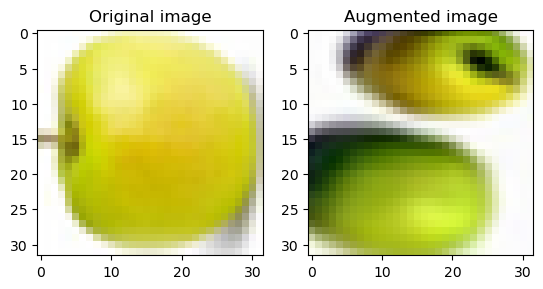

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(samples[0][3].T)

plt.subplot(1,2,2)
plt.title('Augmented image')
plt.imshow(augumented_images[0][0].T)

In [22]:
# sample_index = read_subset_dataset 
sample_index = subset_dataset_new.subset_indices
X_train = []
y_train = []
for i in sample_index:
    X = new_cifar[i][0]
    X_train.append(X)
    y = new_cifar[i][1]
    y_train.append(y)

im_subset_train_data = [(X, y) for X, y in zip(X_train, y_train)] #包装为数据对
# trainDataLoader = torch.utils.data.DataLoader(sampled_train_data, batch_size=16, shuffle=True)

In [23]:
less50 = 0
more50 = 0
for X,y in im_subset_train_data:
    if y<50:
        less50+=1
    else:
        more50+=1
print(less50,more50)

22449 17513


In [24]:
from train_changedata import main

# main(train_dataset= cifar100)
best_acc, confusion_matrix, best_f1, best_recall = main(train_dataset=im_subset_train_data)

{'net': 'vgg16', 'gpu': True, 'b': 100, 'warm': 1, 'lr': 0.1, 'resume': False}
train_data loader is ready
Files already downloaded and verified
test_data loader is ready
Training Epoch: 1 [39962/39962]	Loss: 4.0686	LR: 0.100000
epoch 1 training time consumed: 55.73s
Evaluating Network.....
Test set: Epoch: 1, Average loss: 0.0471, Accuracy: 0.0284, Time consumed:14.60s



d:\anaconda\anaconda3\envs\260d\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Epoch: 2 [39962/39962]	Loss: 3.8547	LR: 0.100000
epoch 2 training time consumed: 54.12s
Evaluating Network.....
Test set: Epoch: 2, Average loss: 0.0464, Accuracy: 0.0309, Time consumed:15.04s

Training Epoch: 3 [39962/39962]	Loss: 3.7893	LR: 0.100000
epoch 3 training time consumed: 55.43s
Evaluating Network.....
Test set: Epoch: 3, Average loss: 0.0460, Accuracy: 0.0407, Time consumed:14.97s

Training Epoch: 4 [39962/39962]	Loss: 3.7202	LR: 0.100000
epoch 4 training time consumed: 54.45s
Evaluating Network.....
Test set: Epoch: 4, Average loss: 0.0446, Accuracy: 0.0437, Time consumed:15.28s

Training Epoch: 5 [39962/39962]	Loss: 3.7057	LR: 0.100000
epoch 5 training time consumed: 55.75s
Evaluating Network.....
Test set: Epoch: 5, Average loss: 0.0437, Accuracy: 0.0534, Time consumed:15.21s

Training Epoch: 6 [39962/39962]	Loss: 3.8880	LR: 0.100000
epoch 6 training time consumed: 55.94s
Evaluating Network.....
Test set: Epoch: 6, Average loss: 0.0454, Accuracy: 0.0508, Time co

best accuracy: tensor(0.3242, device='cuda:0')
best f1score tensor(0.3242)
best recall tensor(0.3242)
[[45  0  1 ...  0  1  0]
 [ 0  7  0 ...  0  0  2]
 [ 1  0  6 ...  0 27  0]
 ...
 [ 0  0  0 ... 39  4  1]
 [ 0  0  3 ...  0 43  2]
 [ 0  0  0 ...  0  0 50]]


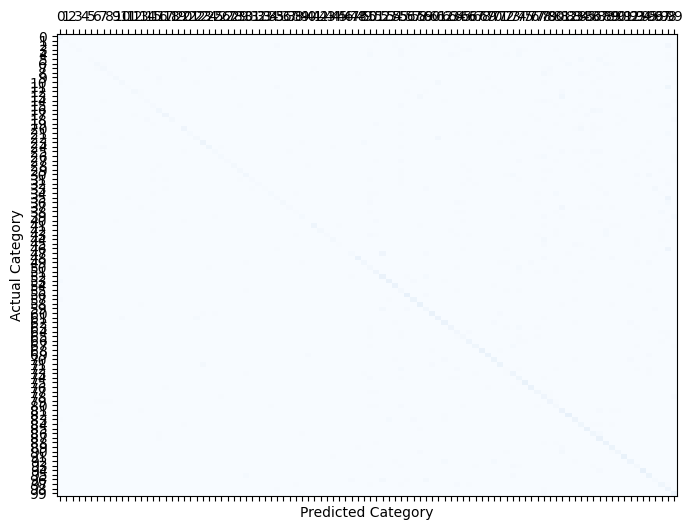

In [26]:
print('best accuracy:',best_acc)
print('best f1score',best_f1)
print('best recall',best_recall)

print(confusion_matrix)
import matplotlib.pyplot as plt

classes = range(100)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(100), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(100), classes)
plt.show()